<center>
  <img src="assets/lamac-uece.png" width="450">
  <h2>Universidade Estadual do Ceará</h2>
  <h2>Laboratório de Matemática Computacional (LaMaC)</h2>
</center>

## Disciplina de Fundamentos de Análise de Dados

**Docente**: Prof. Thelmo Pontes de Araújo, Ph.D.<br>
**Discente**: B.Sc. Gabriel Furtado Lins Melo

---

### Classificação: SVD

A Decomposição de Valor Singular (SVD), como visto, encontra os au-
tovetores e (a raiz quadrada dos) autovalores da matriz de covariância dos
dados X T X , sem calculá-la explicitamente. Assim, a redução de dimensio-
nalidade para o problema de classificação pode ser realizada utilizando

$$ X = USV^T $$

### 1 Banco de Dados

Inicialmente, obtemos o nome de arquivo dos dados do dataset e seus rótulos (labels). Então pegamos, também, os rótulos individualmente (unique_labels)

In [1]:
import os

DATASET_PATH = 'dataset/dataset/'

filenames = os.listdir(DATASET_PATH)
labels = [filename.split(' ')[0] for filename in filenames]
unique_labels = set(labels)

print(f'Number of labels: {len(unique_labels)}')
print(unique_labels)

Number of labels: 50
{'3063', '33909', '15672', '3038', '3046', '3004', '3298', '99301', '3623', '3001', '43093', '4490', '3068', '2420', '6143', '3045', '3010', '3037', '54200', '6632', '3794', '4286', '3022', '2780', '3021', '27925', '3002', '3062', '4150', '18654', '3003', '3020', '3675', '43857', '3069', '3024', '85984', '41678', '41677', '3005', '3070', '3023', '14719', '3700', '3040', '3659', '2357', '3622', '4274', '3039'}


Então, carregaremos em um DataFrame Pandas os nomes de arquivos e os labes (não iremos carregar as imagens em memória até o momento adequado) e usamos o scikit-learn para separá-lo em conjuntos de treinamento e teste (60% / 40%).

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.DataFrame({'Image File': filenames, 'Lego Type': labels})
train_data, test_data = train_test_split(data, test_size=0.4, stratify=data['Lego Type'], random_state=43)

In [3]:
train_size_per_class = len(train_data[train_data['Lego Type'] == '3068'])
print(train_size_per_class)

print("Training data:")
print(train_data)

print("Test data:")
print(test_data)

480
Training data:
                             Image File Lego Type
19611           3023 Plate 1x2 293L.png      3023
2724        3659 brick bow 1x4 045R.png      3659
20079       3038 roof tile 2x3 262R.png      3038
11052      85984 roof tile 1x2 223R.png     85984
8848       15672 roof tile 1x2 246R.png     15672
...                                 ...       ...
19143  2357 brick corner 1x2x2 088L.png      2357
18377            18654 beam 1M 195R.png     18654
38218      54200 roof tile 1x1 276L.png     54200
14542           3001 brick 2x4 321R.png      3001
4288      3062 Round Brick 1x1 355R.png      3062

[24000 rows x 2 columns]
Test data:
                                         Image File Lego Type
22816               2780 Peg with friction 106L.png      2780
20608  43093 Bush 2M friction - Cross axle 079R.png     43093
21816           99301 roof tile inside 3x3 336L.png     99301
35393                   4286 roof tile 1x3 300L.png      4286
8822               2357 brick corn

Agora, vamos carregar as imagens de treinamento no DataFrame

In [4]:
from PIL import Image
import numpy as np

def load_image(image_path):
    img = np.asarray(Image.open(os.path.join(DATASET_PATH, image_path)).convert('L'))
    return img

train_data['Image'] = train_data['Image File'].apply(load_image)

In [5]:
print('Training data:')
print(train_data)

Training data:
                             Image File Lego Type  \
19611           3023 Plate 1x2 293L.png      3023   
2724        3659 brick bow 1x4 045R.png      3659   
20079       3038 roof tile 2x3 262R.png      3038   
11052      85984 roof tile 1x2 223R.png     85984   
8848       15672 roof tile 1x2 246R.png     15672   
...                                 ...       ...   
19143  2357 brick corner 1x2x2 088L.png      2357   
18377            18654 beam 1M 195R.png     18654   
38218      54200 roof tile 1x1 276L.png     54200   
14542           3001 brick 2x4 321R.png      3001   
4288      3062 Round Brick 1x1 355R.png      3062   

                                                   Image  
19611  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2724   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
20079  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
11052  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
8848   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Visualizando uma imagem do DataFrame

Image File            3046 roof corner inside tile 2x2 395R.png
Lego Type                                                  3046
Image         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: 18825, dtype: object


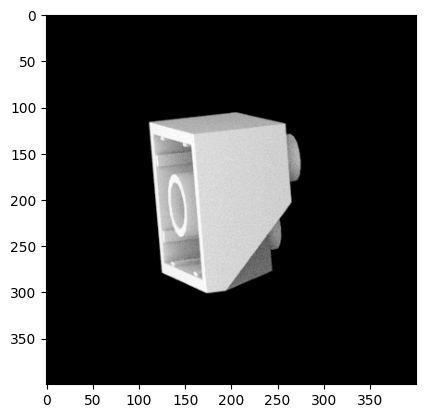

In [6]:
import matplotlib.pyplot as plt

image_sample = train_data.iloc[8]
print(image_sample)

plt.imshow(image_sample['Image'], cmap='gray')


### 2 SVD da matriz de dados centralizados

Antes de calcular o SVD, iremos calcular a matriz de dados centralizados $X$ para os dados de treinamento. Para isto, precisamos achatar cada imagem em um vetor e juntar todas em uma grande matriz $A$, onde as linhas serão as imagens e as colunas serão características.

In [7]:
images = train_data['Image'].to_numpy()
print(f'All images DF shape: {images.shape}')
print(f'Image shape: {images[0].shape}')

A = np.array([image.flatten() for image in images])
print(f'A matrix shape: {A.shape}')
print(A)

All images DF shape: (24000,)
Image shape: (400, 400)
A matrix shape: (24000, 160000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Agora vamos tirar a média de cada coluna de $A$ e subtrair o vetor de médias obtido de A, elemento por elemento

In [8]:
mean_A = np.mean(A, axis=0) # média ao longo das linhas (para cada coluna)
X = A - mean_A

print(mean_A)
print(X)

MemoryError: Unable to allocate 28.6 GiB for an array with shape (24000, 160000) and data type float64

Agora, calculamos a SVD de $X$.

Vamos agora gerar um gráfico de número de valores singulares versus variabilidade acumulada.